In [48]:
# last edited Feb 25 2021 by GO
# Log:  Used ArcMap to determine how to trim map for Ecospace.
#         Exported a copy of the NEMO and the Ecospace grids to SHP. 
#         Wrote to ASC. Fixed the vertical mirroring.        

#
#############################################################################
# purpose: extract Ecospace grid file from NEMO grid file
#
# files in: NEMO-Salish-Sea-2021\data\grid\coordinates_salishsea_1500m.nc
#                                    bathy_salishsea_1500m_20210205.nc
# files out: shapefiles of NEMO and trimmed Ecospace grid
#            ASC file for Ecospace map
#
# Ecospace header template: 
#ncols         56
#nrows         160
#xllcorner     -125.375
#yllcorner     45.2205657958984
#cellsize      0.0179964620620012
#NODATA_value  -9999
#############################################################################

%matplotlib notebook
import netCDF4 as nc
import numpy as np
import pandas as pd
import geopandas as gpd
from helpers import writebathy, expandf
from helpers import gete1, gete2, writecoords, t2u, t2v, t2f
import matplotlib.pyplot as plt
import scipy.io as sio

<IPython.core.display.Javascript object>


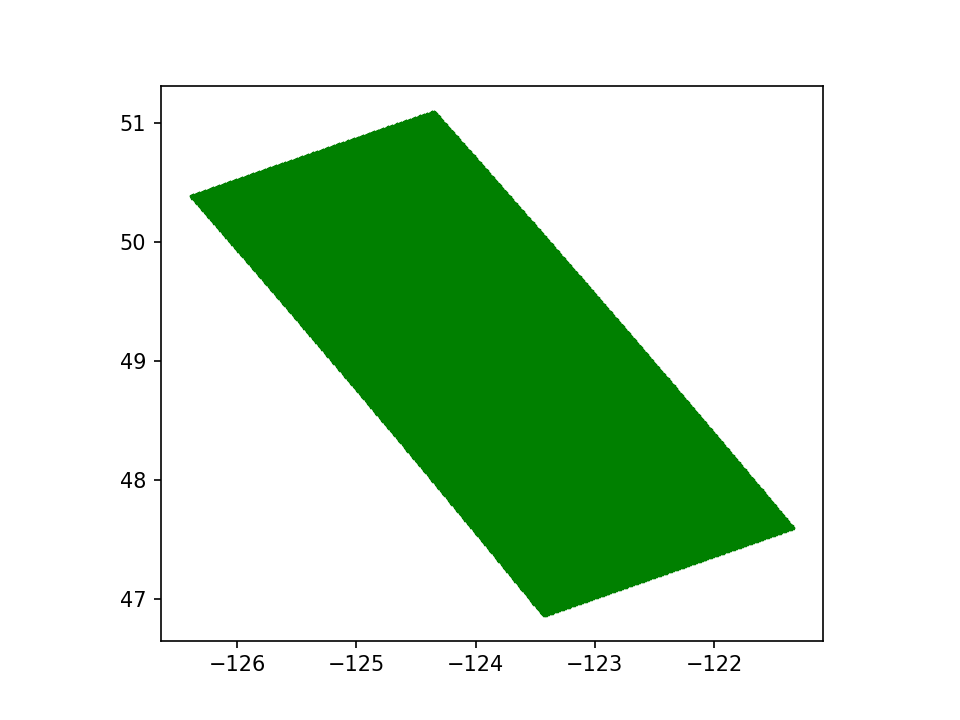

<IPython.core.display.Javascript object>


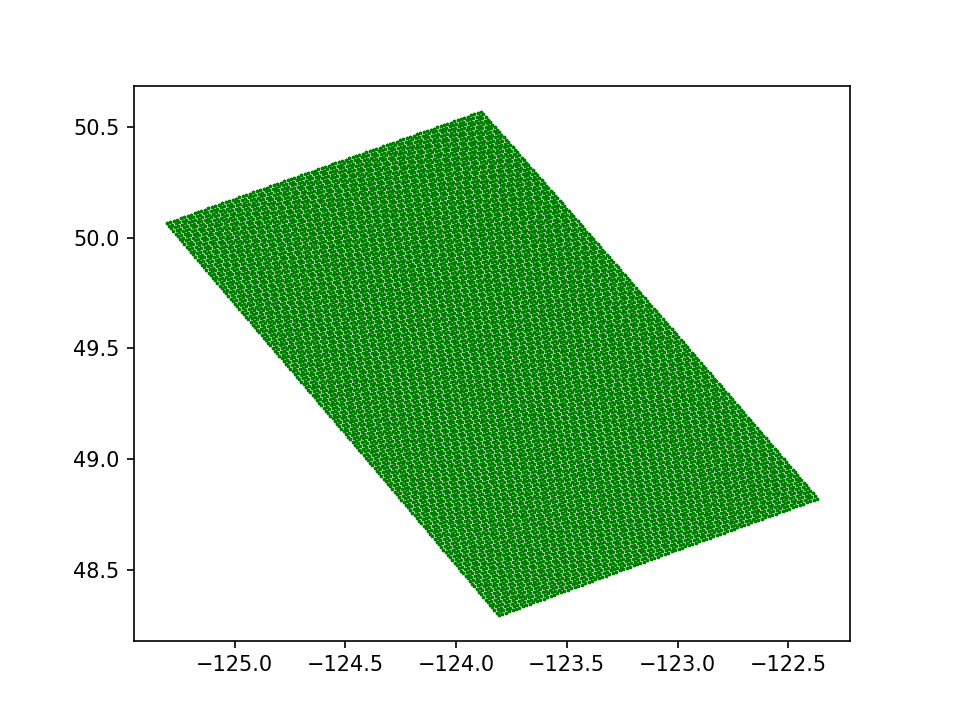

In [75]:
#For a full grid - coordfile
#for just water - bathy
coordfilename = '..//..//NEMO-Salish-Sea-2021//data//grid//coordinates_salishsea_1500m.nc'
bathyfilename = '..//..//NEMO-Salish-Sea-2021//data//bathymetry//bathy_salishsea_1500m_20210208.nc'
ecospaceoutfile = '..//data//basemap//ecospacedepthgrid.asc'
datetag = '20210208'

#
# NEMO grid upper left and bottom left pts that define the Ecospace grid. 
#   - Ecospace will use all cols to the right. 
upperleft_row_ewe = 253
upperleft_col_ewe = 39
bottomleft_row_ewe = 102
bottomleft_col_ewe = 39

# functions
def loadcoords(f): 
    with nc.Dataset(coordfilename) as ncid:
        lat_t = ncid.variables["gphit"][0, :, :].filled()
        lon_t = ncid.variables["glamt"][0, :, :].filled()
    return lat_t, lon_t


def loadbathy(f):
    with nc.Dataset(f) as ncid:
        depth = ncid.variables["Bathymetry"][:, :].filled()
        latt = ncid.variables["nav_lat"][:, :].filled()
        lont = ncid.variables["nav_lon"][:, :].filled()
        
    return depth, latt, lont

#############################################################################
########################### EXPORT NEMO GRID SHP ############################
# get coords
depth, lat_t, lon_t = loadbathy(bathyfilename)

i = 0 
coords = []
while i < len(lat_t[:,0]):
    
    coords_row = [list(coord) for coord in zip(lat_t[i,:], 
                                               lon_t[i,:], 
                                               depth[i,:], 
                                               np.arange(0,lat_t.shape[1]), 
                                               np.full((lat_t.shape[1]), i))]
    #print(lat_t[i,:])
    #print(lon_t[i,:])
    coords = coords + coords_row
    i += 1
    
df = pd.DataFrame(coords)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[1],df[0]), crs="EPSG:4326")
gdf.plot( marker='*', color='green', markersize=1)
gdf.rename(columns={0:'lat',1:'lon',2: 'depth', 3:'col',4:'row'}, inplace=True)
#gdf.to_file(driver = 'ESRI Shapefile', filename= "..//data//basemap//NEMO_grid_{}.shp".format(datetag))

#############################################################################
######################### EXPORT ECOSPACE GRID SHP ##########################

i = bottomleft_row_ewe 
j = 0 
coords = []
while i < upperleft_row_ewe:
    
    coords_row = [list(coord) for coord in zip(lat_t[i,upperleft_col_ewe:], 
                                               lon_t[i,upperleft_col_ewe:], 
                                               depth[i,upperleft_col_ewe:], 
                                               np.arange(upperleft_col_ewe,lat_t.shape[1]), # list of col nums
                                               np.full(lat_t.shape[1], i))] # list of the row num i cols long
    coords = coords + coords_row
    
    # store the lower left lat / lon for Ecospace header
    if i == bottomleft_row_ewe:
        xllcorner = coords_row[0][1]
        yllcorner = coords_row[0][0]
    i += 1
    
df = pd.DataFrame(coords)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[1],df[0]), crs="EPSG:4326")
gdf.plot( marker='*', color='green', markersize=1)
gdf.rename(columns={0:'lat',1:'lon',2: 'depth', 3:'NEMO_col',4:'NEMO_row'}, inplace=True)
#gdf.to_file(driver = 'ESRI Shapefile', filename= "..//data//basemap//Ecospace_grid_{}.shp".format(datetag))


In [78]:
#############################################################################
######################### EXPORT ECOSPACE ASC FILE ##########################

i = bottomleft_row_ewe 
j = 0 
coords = []
depthrows = []
print(type(depthrows))

while i < upperleft_row_ewe:
    depthrows.append(depth[i,upperleft_col_ewe:])
    i += 1

depthrows.reverse()

headerlines = []
headerlines.append(["ncols         " + str(len(depthrows[0]))])
headerlines.append(["nrows         " + str(len(depthrows))])
headerlines.append(["xllcorner     " + str(xllcorner)])
headerlines.append(["yllcorner     " + str(yllcorner)])
headerlines.append(["cellsize      1500"])
headerlines.append(["NODATA_value  0.0"])

# when using 'with' the file is automatically closed by python io
with open(ecospaceoutfile,'w',encoding = 'utf-8') as f:
    for h in headerlines: 
        f.write(h[0])
        f.write("\n")
    for n in depthrows: 
        a_str = ' '.join(str(x.astype(int)) for x in n) # '0,3,5'
        f.write(a_str)
        f.write("\n")

<class 'list'>


In [72]:
print(len(depthrows[0]))
print(len(depthrows))

93
151


In [15]:
"..//..//data//basemap//NEMO_grid_{}.shp".format(datetag)

'..//..//data//basemap//NEMO_grid_20210205.shp'

In [67]:
df

,0,1,2,3,4,geometry
0,48.294708,-123.807388,178.819444,39,102,POINT (-123.80739 48.29471)
1,48.300541,-123.791809,178.305556,40,102,POINT (-123.79181 48.30054)
2,48.306370,-123.776222,174.118056,41,102,POINT (-123.77622 48.30637)
3,48.312199,-123.760635,170.569444,42,102,POINT (-123.76064 48.31220)
4,48.318024,-123.745049,161.229167,43,102,POINT (-123.74505 48.31802)
...,...,...,...,...,...,...
14038,50.547035,-123.947533,0.000000,127,252,POINT (-123.94753 50.54704)
14039,50.552395,-123.932281,0.000000,128,252,POINT (-123.93228 50.55239)
14040,50.557755,-123.917030,0.000000,129,252,POINT (-123.91703 50.55775)
14041,50.563114,-123.901779,0.000000,130,252,POINT (-123.90178 50.56311)


In [4]:
gdf

,lat,lon,depth,NEMO_col,NEMO_row,geometry
0,48.294708,-123.807388,178.819444,39,102,POINT (-123.80739 48.29471)
1,48.300541,-123.791809,178.305556,40,102,POINT (-123.79181 48.30054)
2,48.306370,-123.776222,174.118056,41,102,POINT (-123.77622 48.30637)
3,48.312199,-123.760635,170.569444,42,102,POINT (-123.76064 48.31220)
4,48.318024,-123.745049,161.229167,43,102,POINT (-123.74505 48.31802)
...,...,...,...,...,...,...
14038,50.547035,-123.947533,0.000000,127,252,POINT (-123.94753 50.54704)
14039,50.552395,-123.932281,0.000000,128,252,POINT (-123.93228 50.55239)
14040,50.557755,-123.917030,0.000000,129,252,POINT (-123.91703 50.55775)
14041,50.563114,-123.901779,0.000000,130,252,POINT (-123.90178 50.56311)


In [76]:
xllcorner

-123.80739